In [162]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

warnings.filterwarnings('ignore')

DIR = "C:/Users/Yipeng/Contest/BDCI2023/code/"
DIR_DATA_RAW = DIR + "data/"
DIR_DATA_PRE = DIR + "data/preprocessed/"
DIR_MODEL = DIR + "model/"
DIR_MODEL_LGB = DIR_MODEL + "lgb/"

In [163]:
import lightgbm as lgb

data_merged = pd.read_pickle(DIR_DATA_PRE + "data_merged.pkl")

In [164]:
lst = []
for day in [1,3,5,7,14,21,30,60,90]:
    lst.append(f"sales_{day}_mean")
    lst.append(f"sales_{day}_std")
    lst.append(f"sales_{day}_mean_change")
data_merged.drop(lst, axis=1, inplace=True)

In [201]:
def test_by_store_id(store_id: int = -1):
    # 加载模型
    model = lgb.Booster(model_file=DIR_MODEL_LGB + f'partial_365_iteration_1000.txt')
    # 加载要预测的数据
    if store_id == -1:
        data_store = data_merged
    else:
        data_store = data_merged[data_merged['store_id'] == store_id]
    data_pred = data_store[data_store['date'] >= '2023-08-31']
    # 预测
    data_pred['quantity'] = model.predict(data_pred.drop(["quantity", "date"], axis=1))
    # 只保留需要的列
    data_pred = data_pred[['store_id', 'sku_id', 'date', 'quantity']]
    return data_pred


In [202]:
# pred_all_list = []
# for store_id in range(1, 13):
#     print(f"predicting store_id={store_id} ...")
#     pred_all_list.append(test_by_store_id(store_id))
# pred_all = pd.concat(pred_all_list)
pred_all = test_by_store_id()

In [203]:
pred_all

,store_id,sku_id,date,quantity
1460,1,1,2023-08-31,1.051906
1462,1,1,2023-09-01,1.423165
1464,1,1,2023-09-02,1.991199
1466,1,1,2023-09-03,1.895785
1468,1,1,2023-09-04,1.039261
...,...,...,...,...
10262841,12,1000,2023-09-10,0.470098
10262843,12,1000,2023-09-11,0.334284
10262845,12,1000,2023-09-12,0.320671
10262847,12,1000,2023-09-13,0.433179


In [204]:
pred_all['quantity'] = pred_all['quantity'].apply(lambda x: 0 if x < 0.5 else ceil(x))

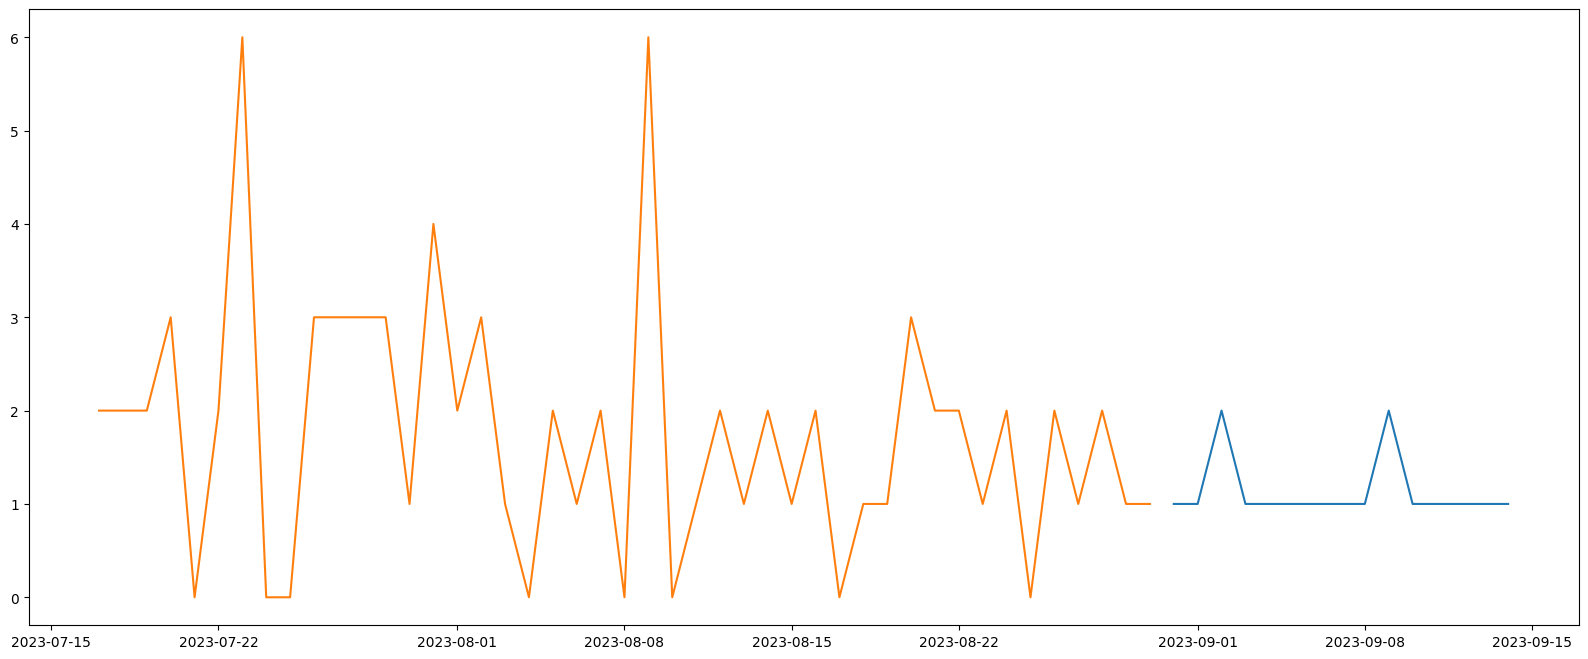

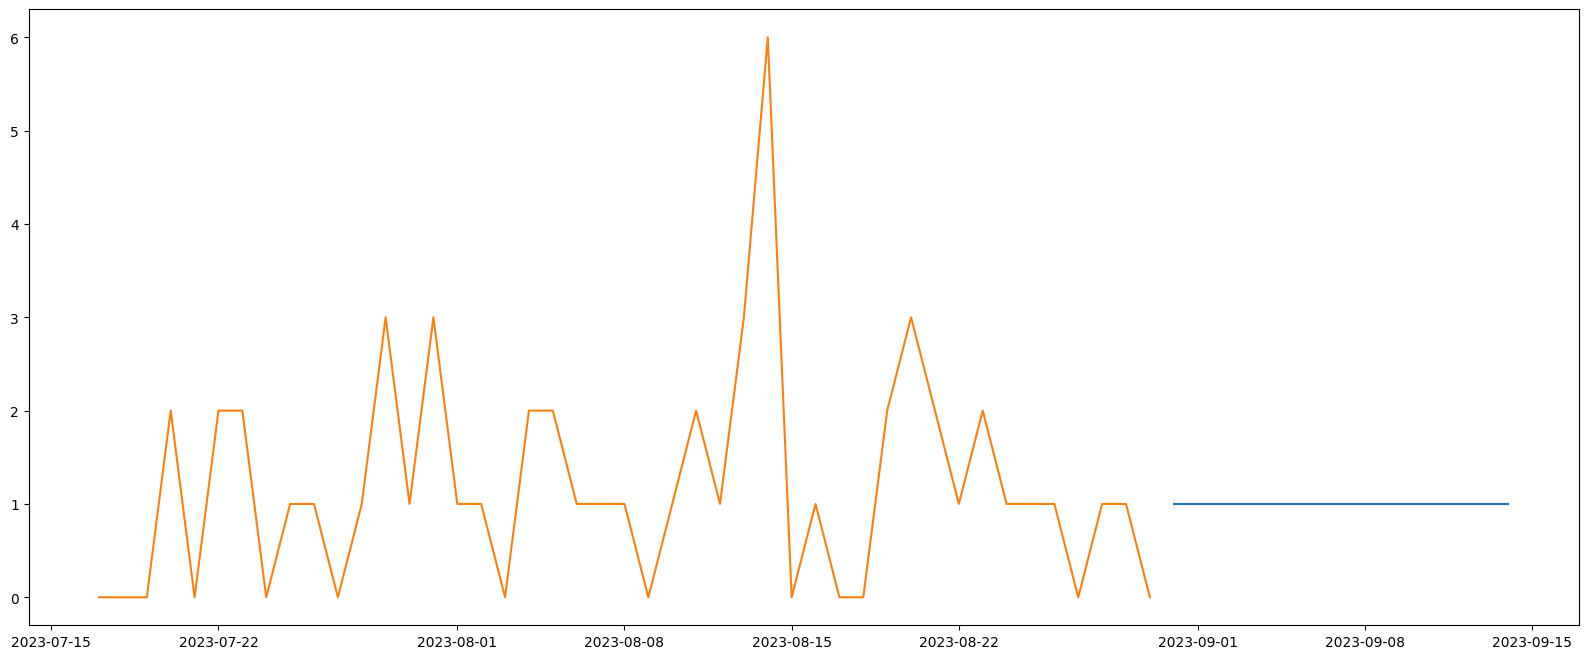

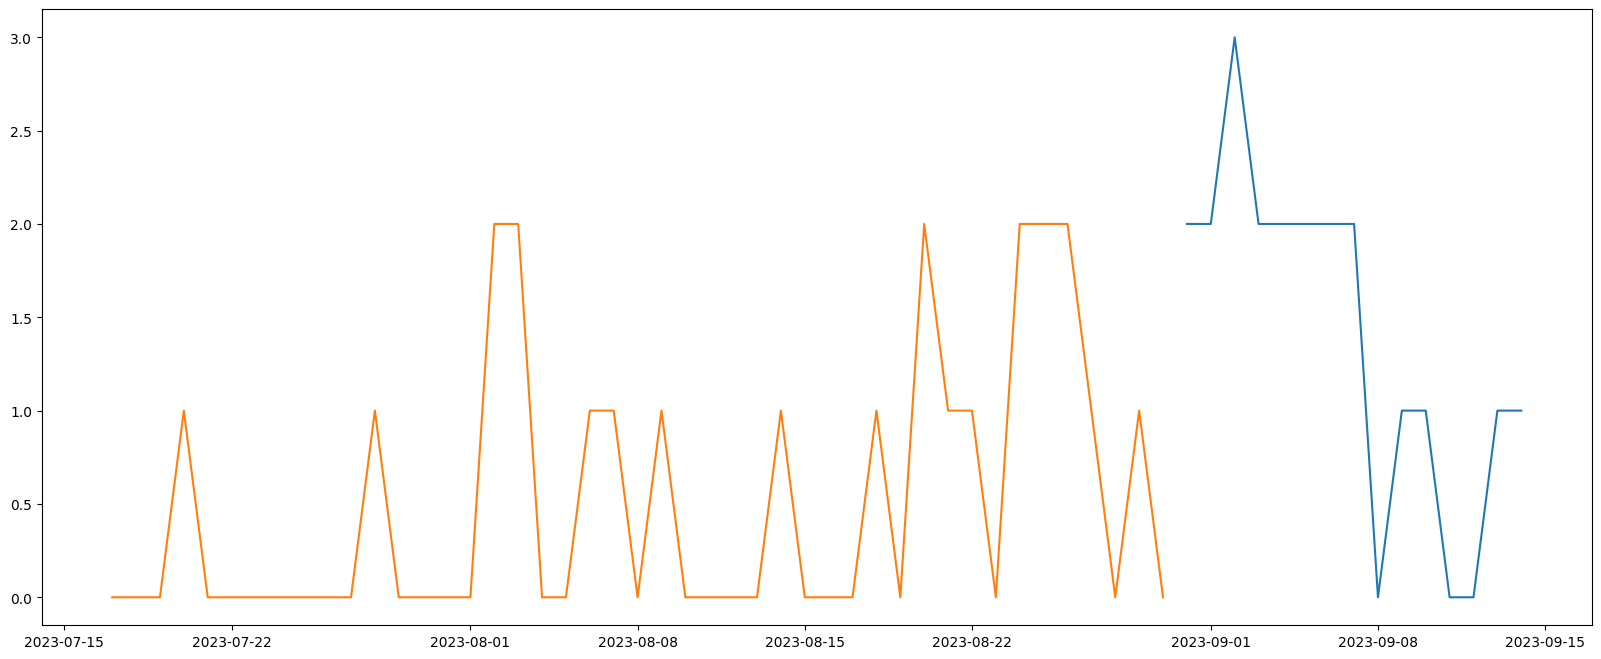

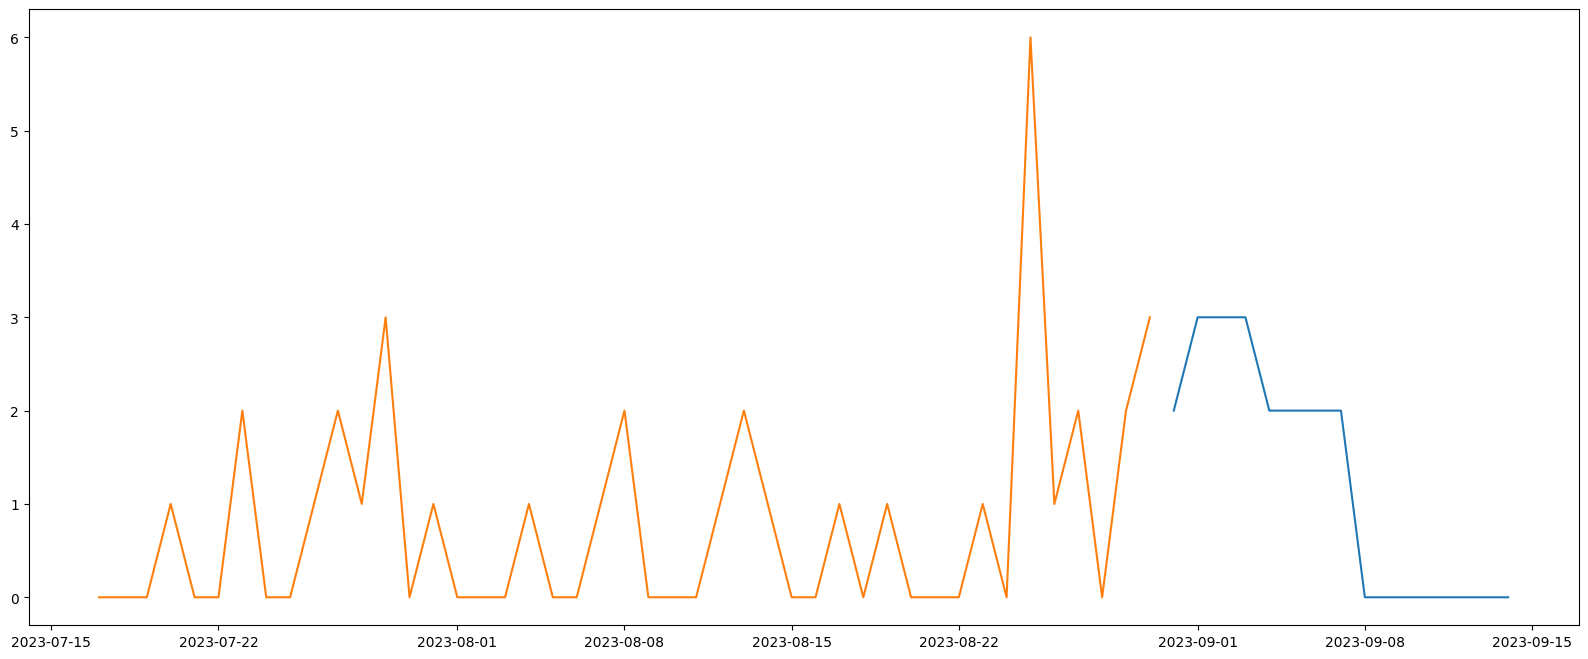

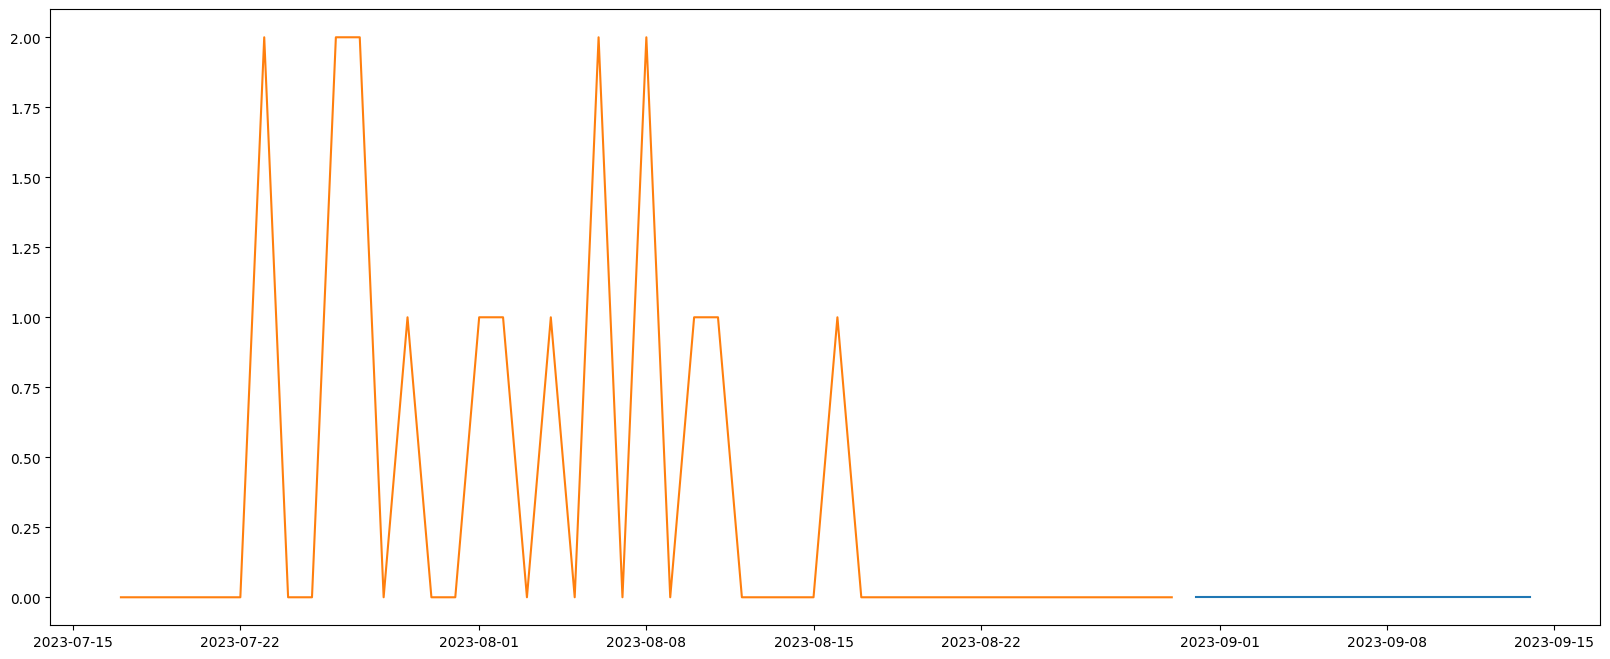

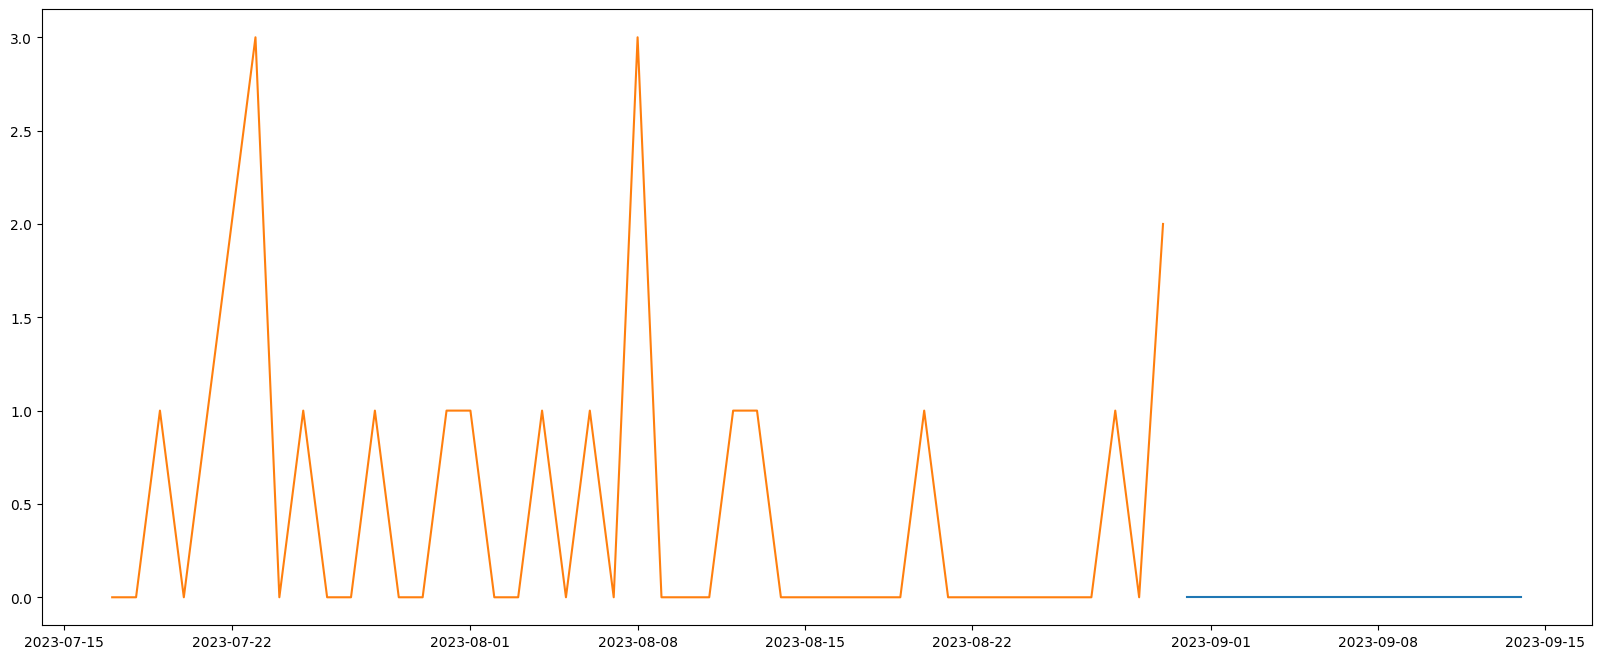

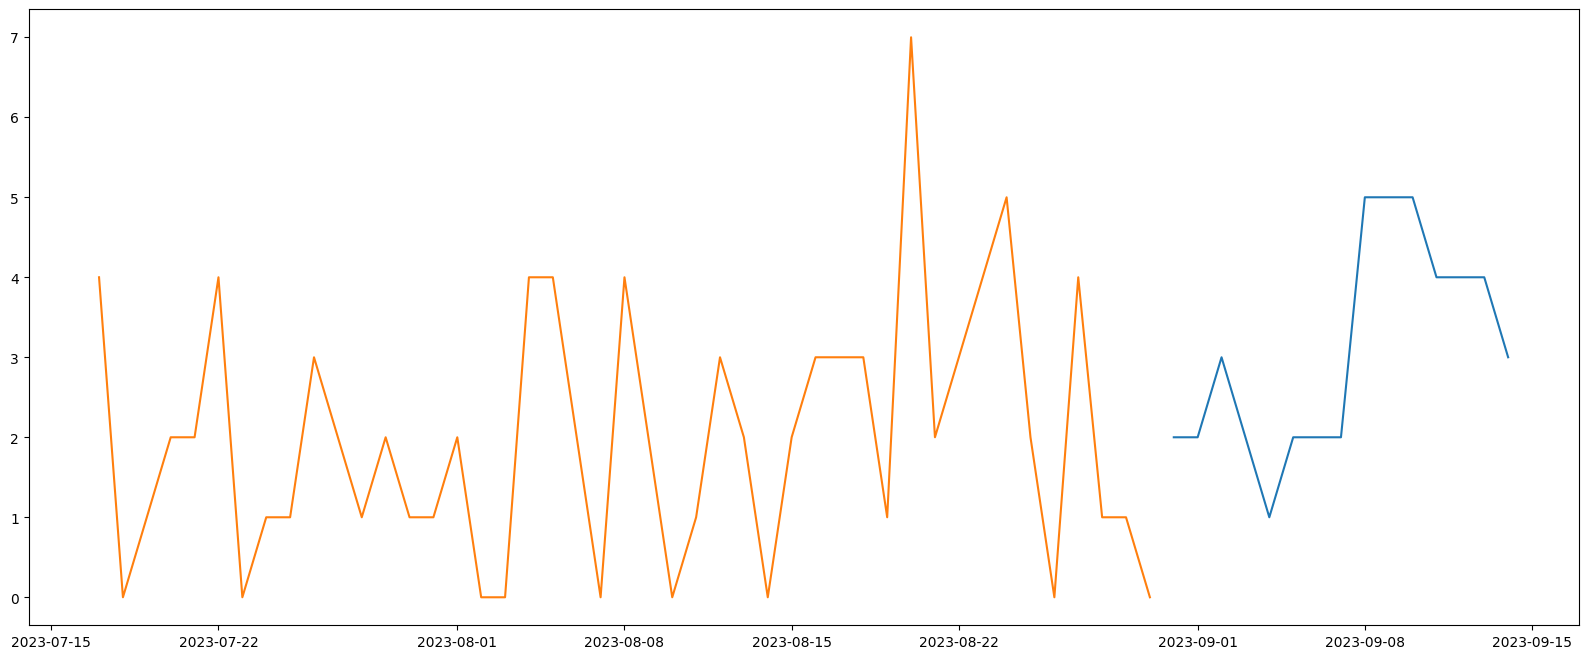

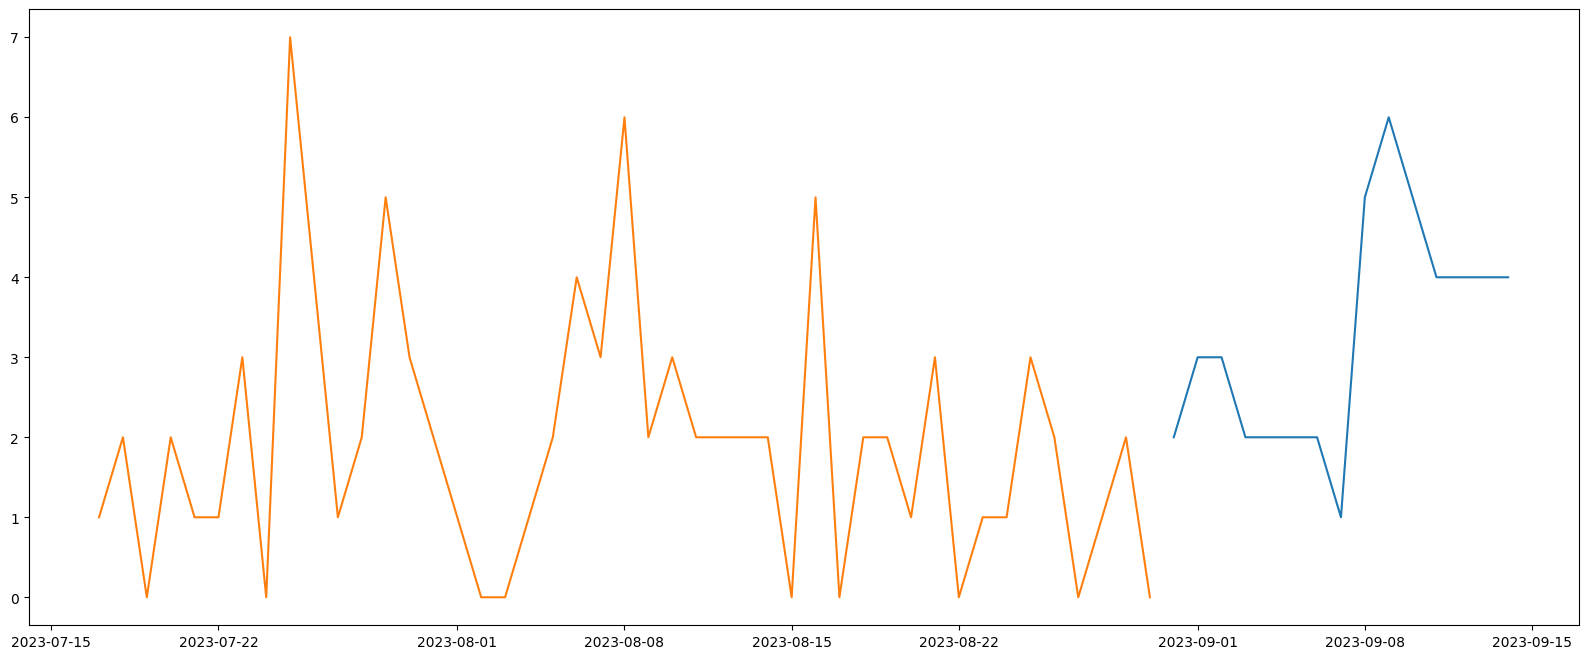

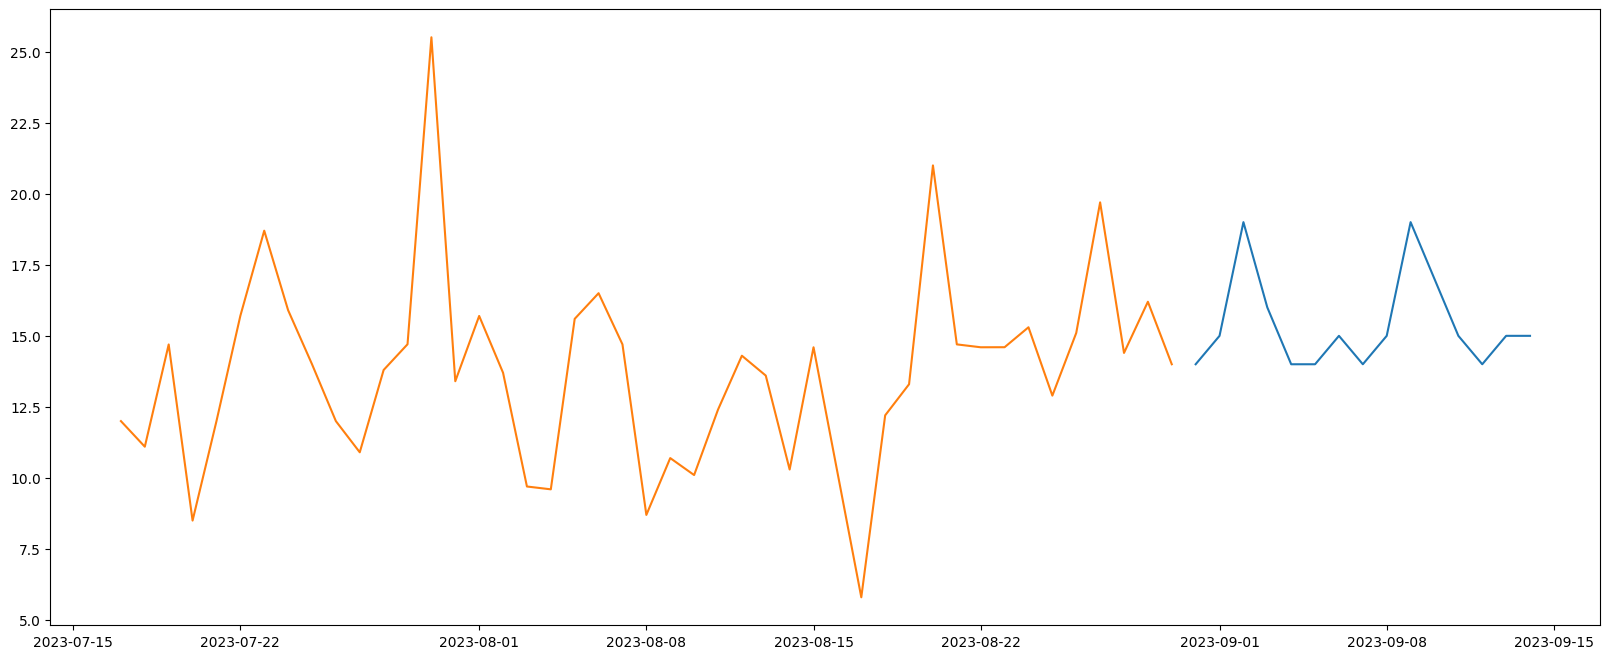

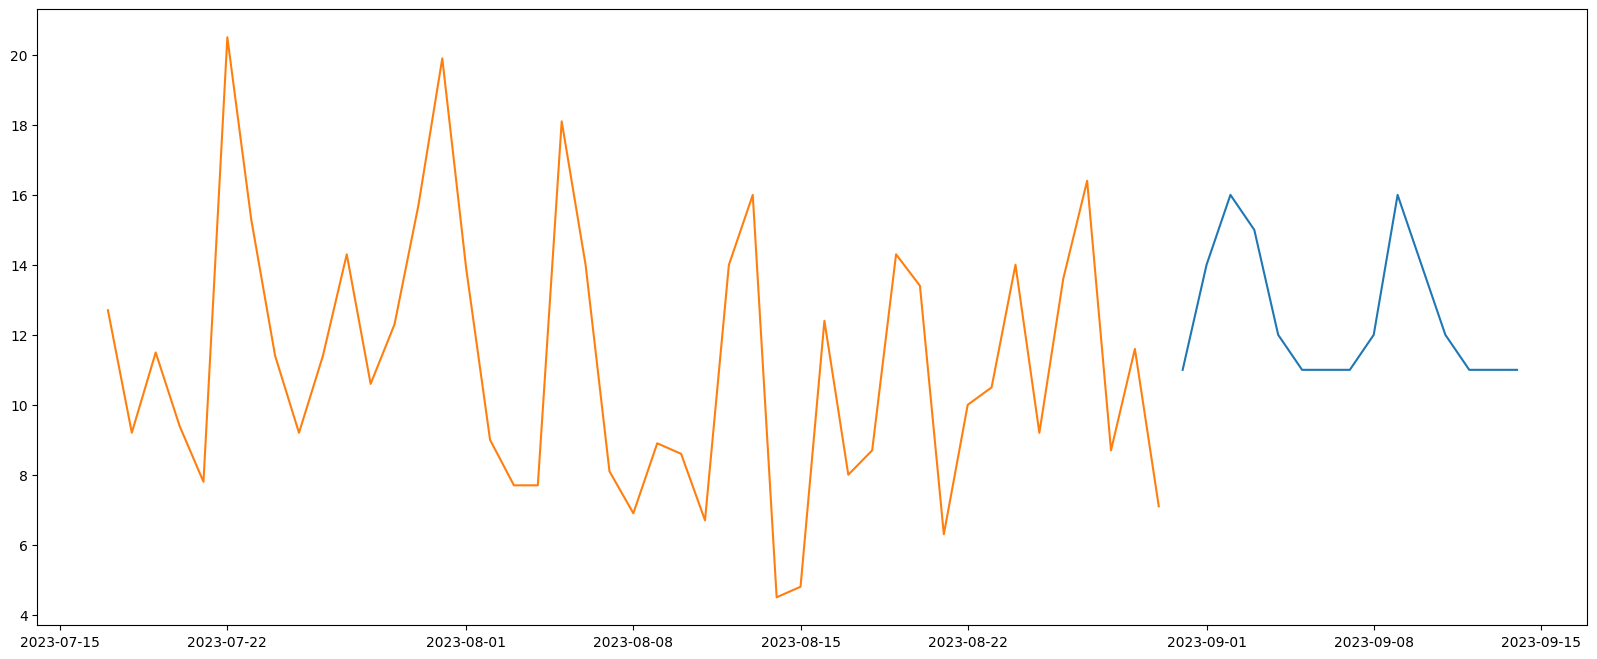

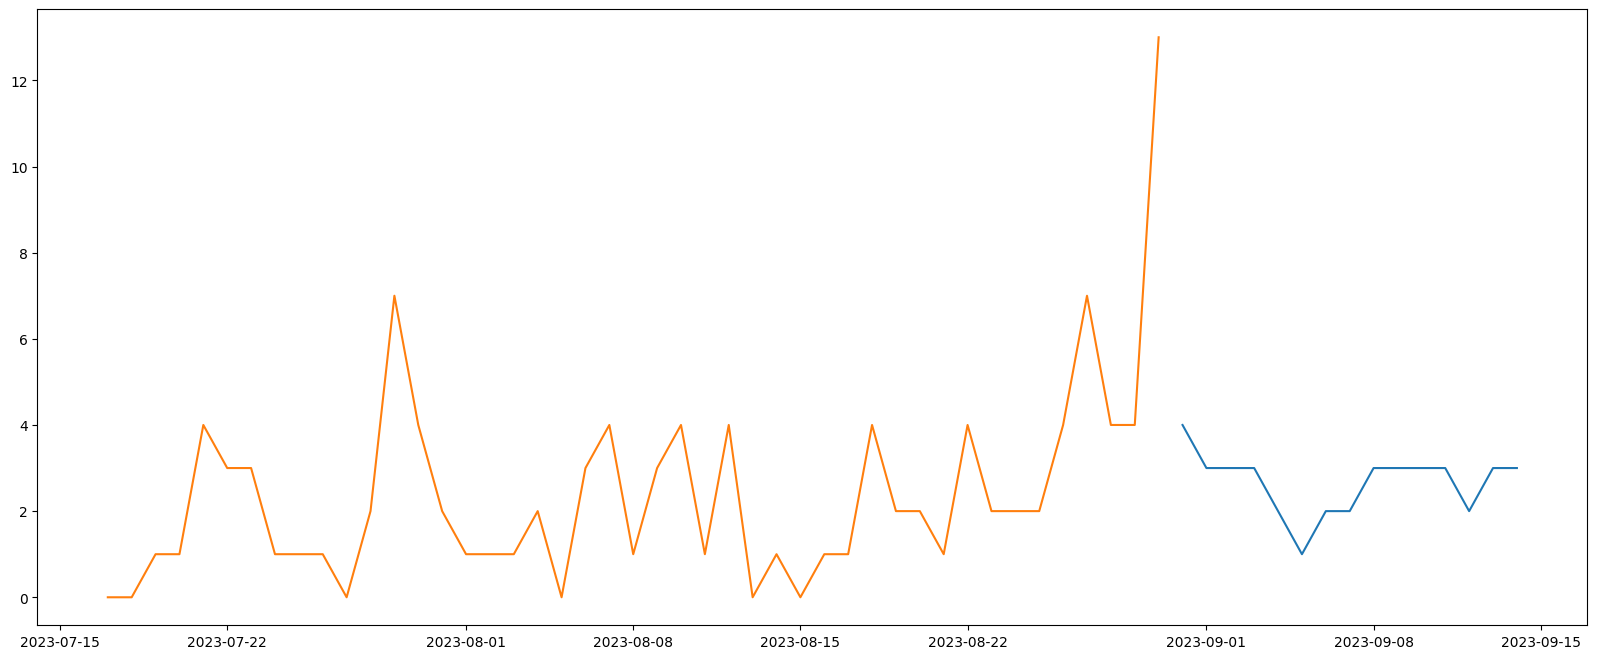

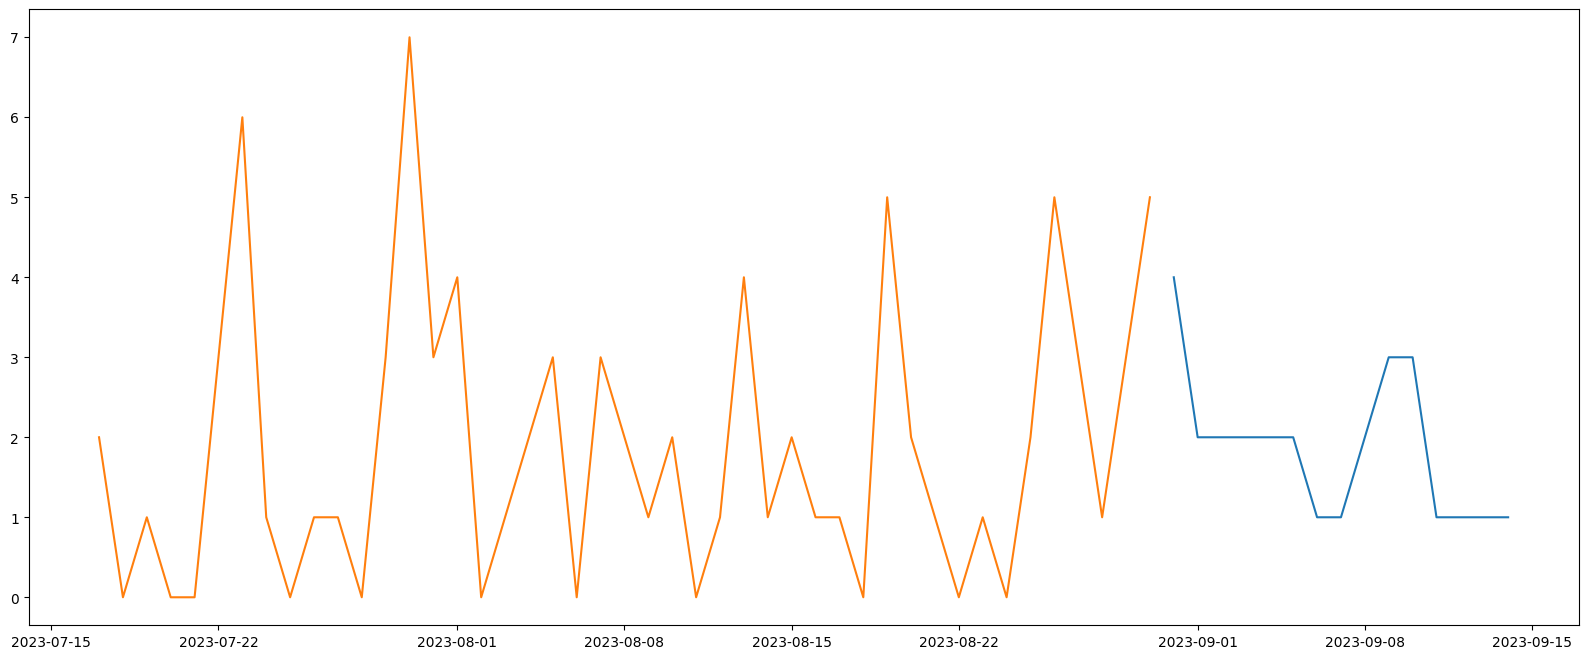

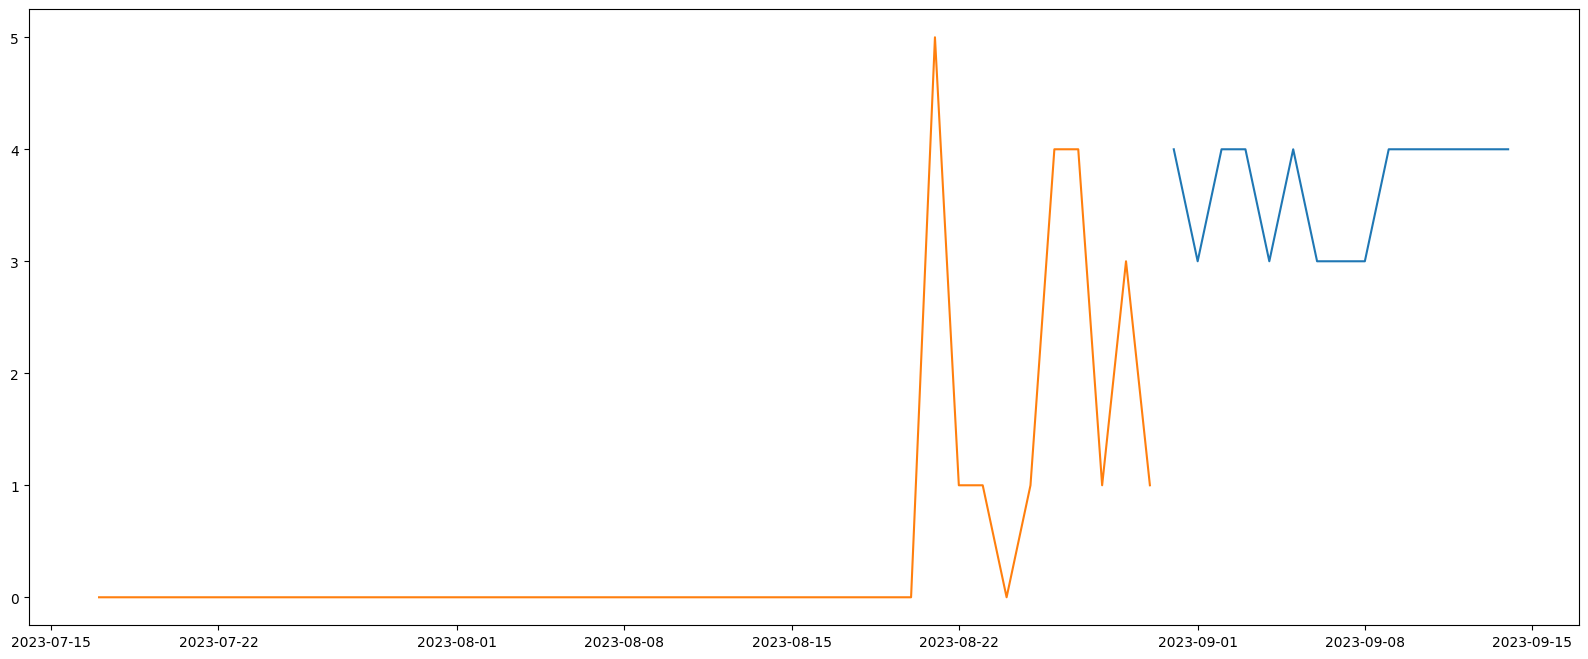

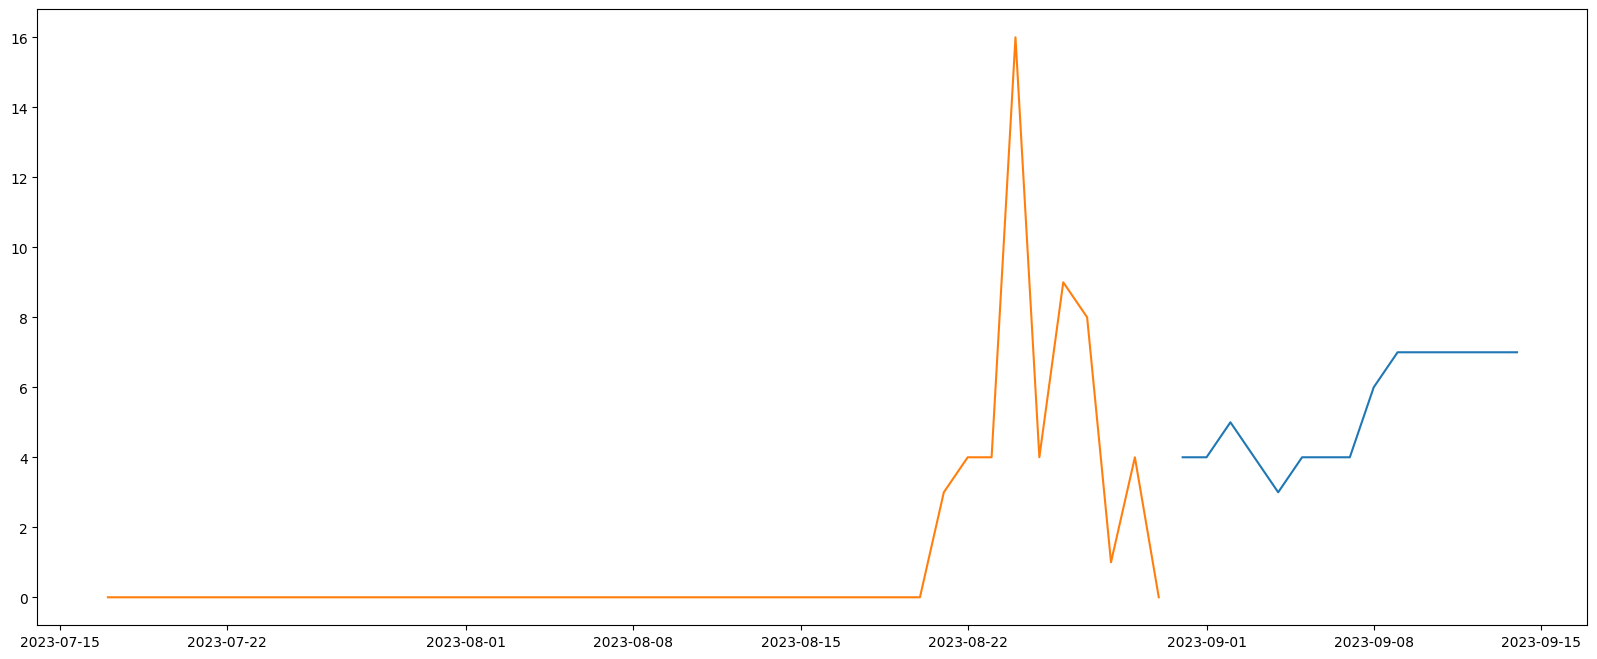

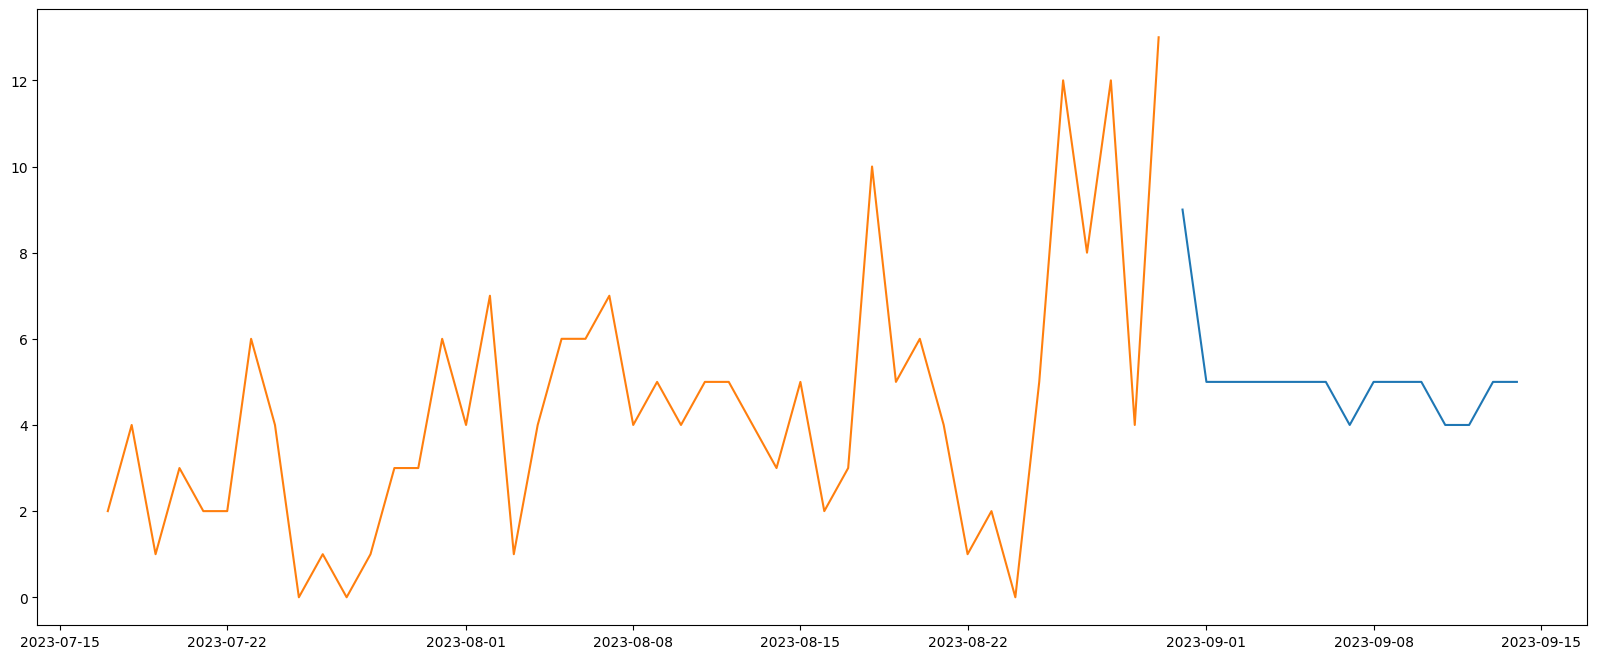

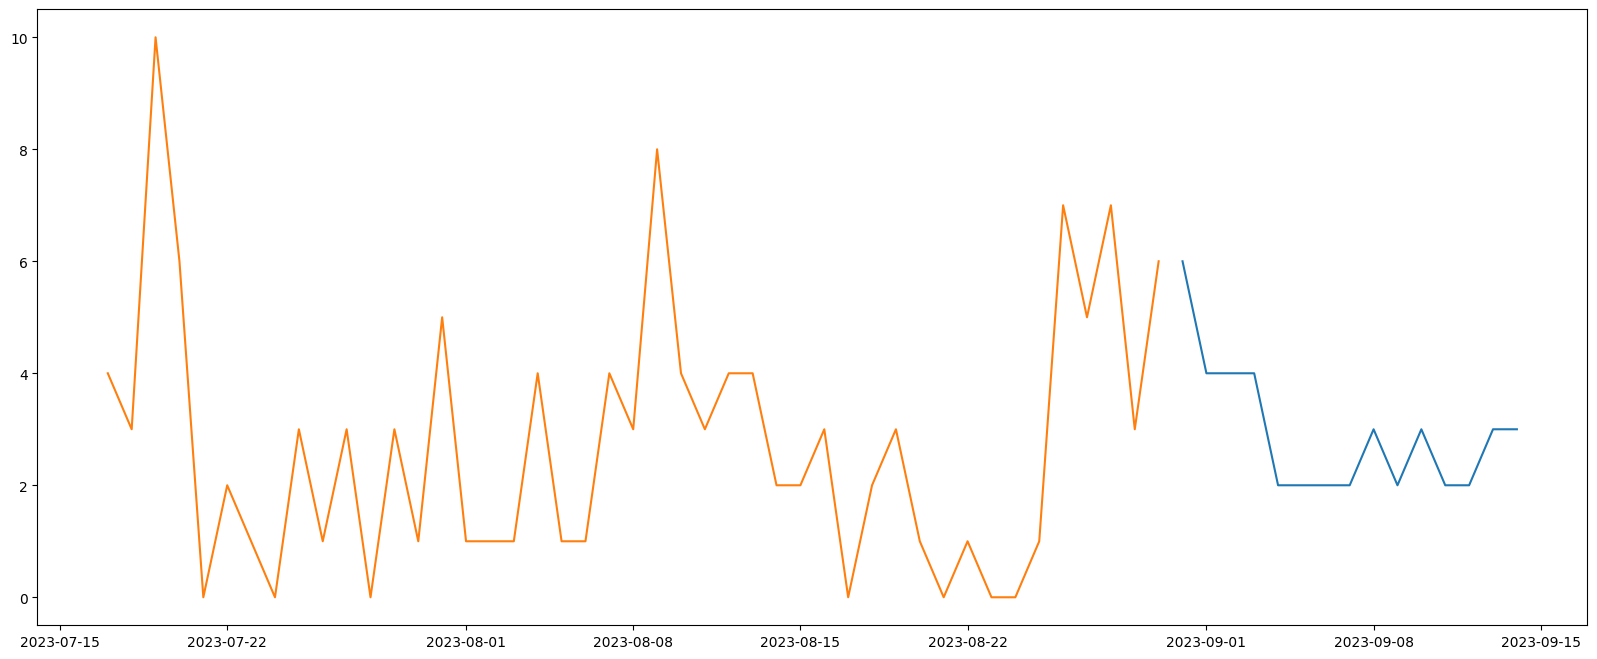

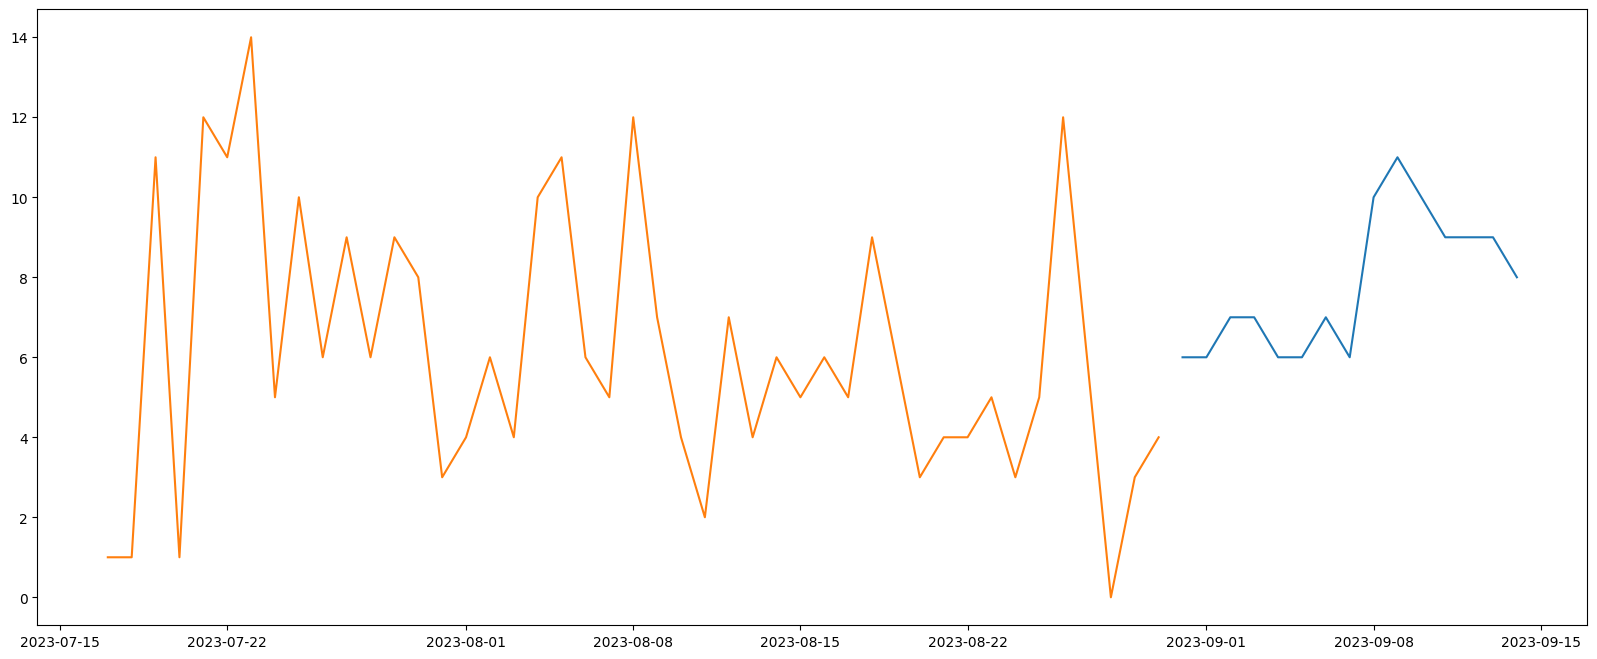

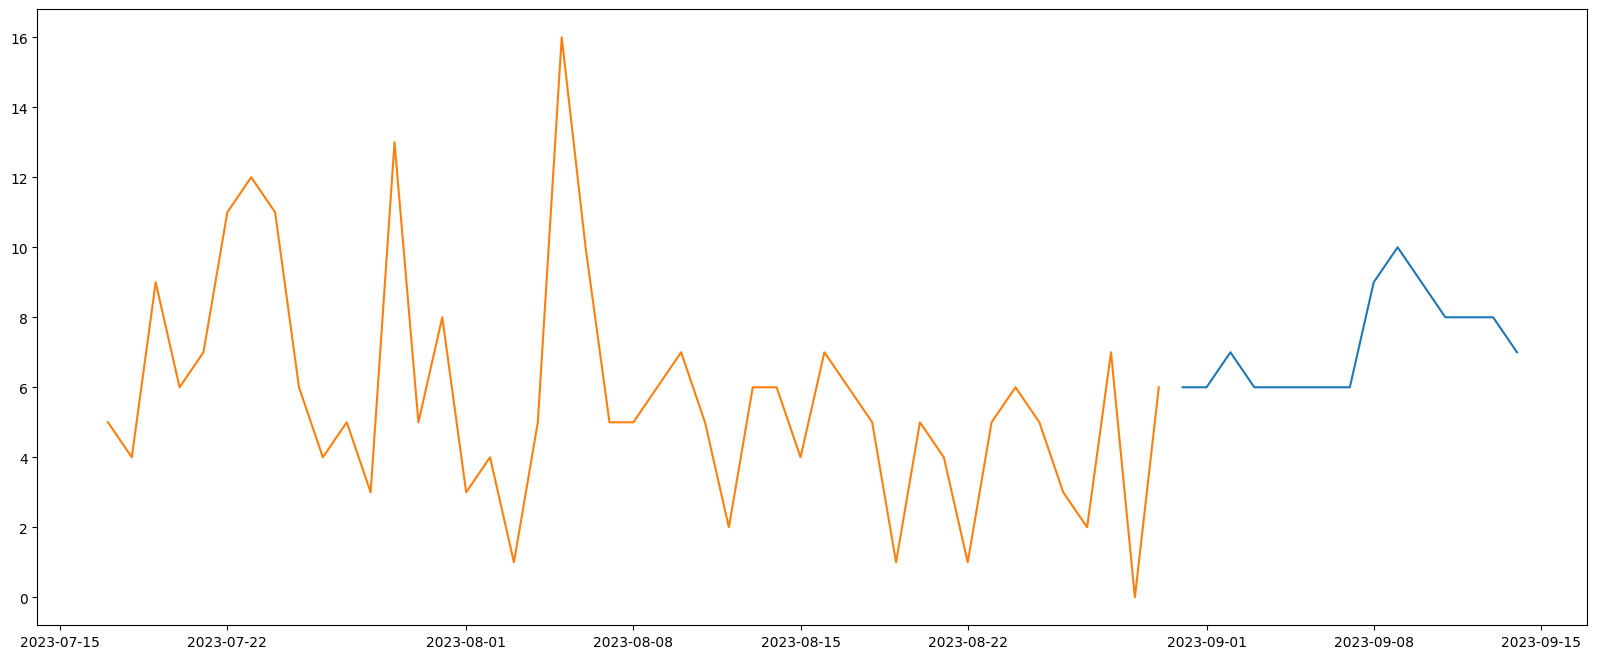

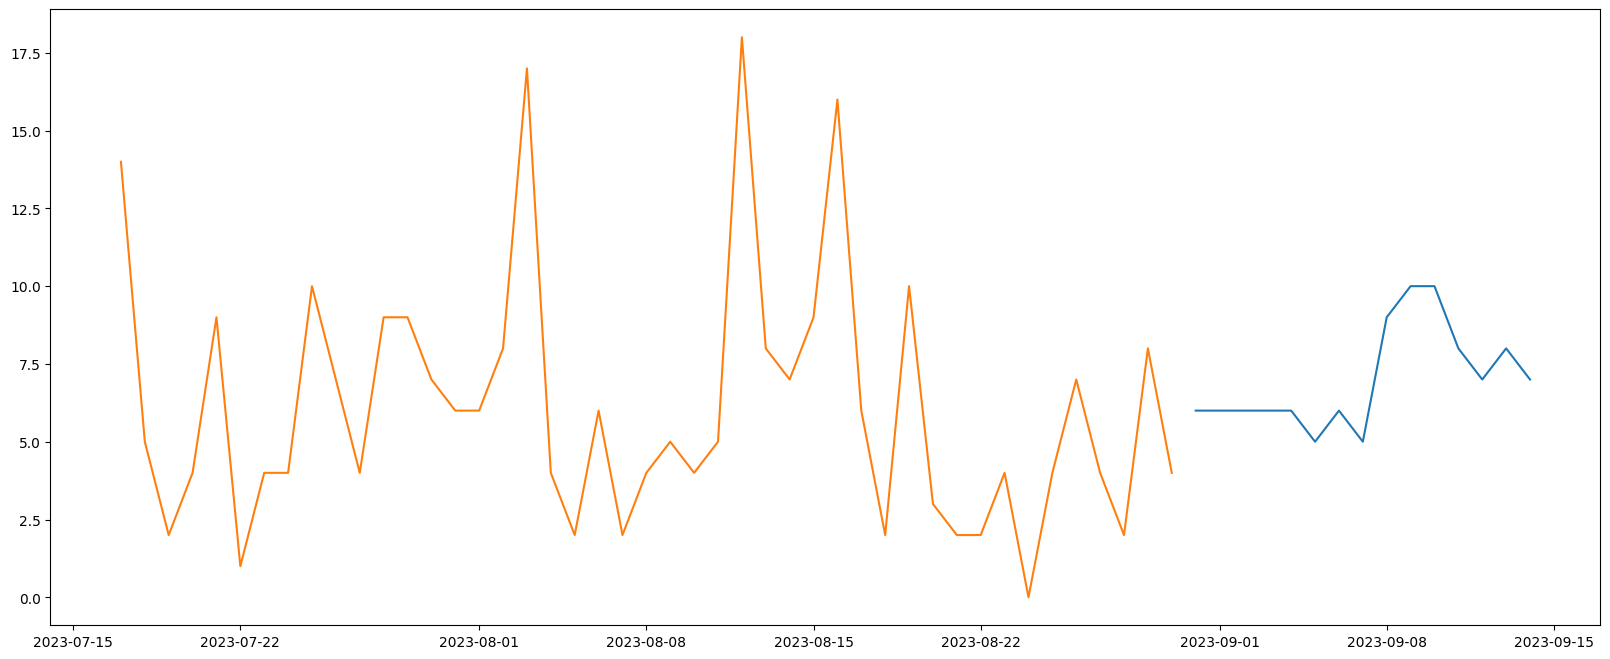

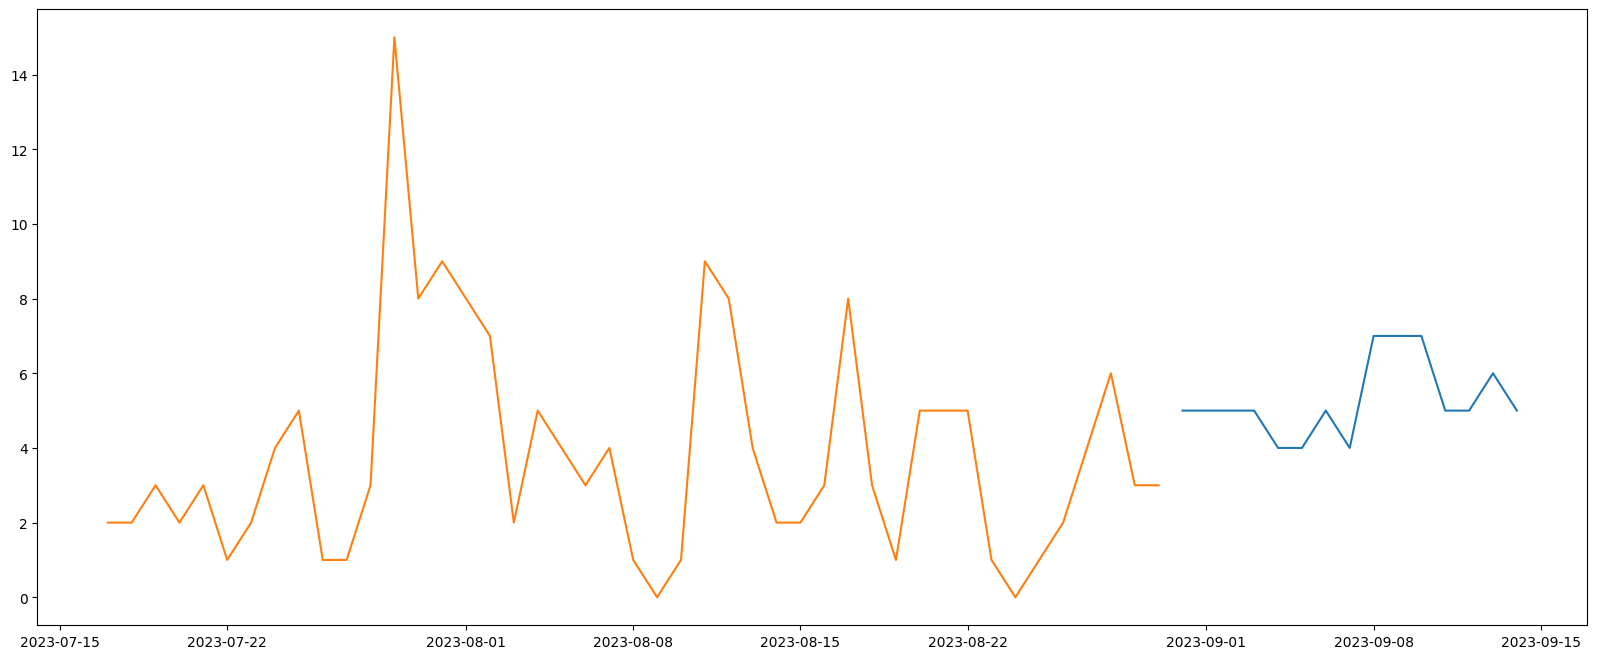

In [205]:
for sku_id in range(40, 50):
    for store_id in [10, 11]:
        temp = pred_all[(pred_all['sku_id'] == sku_id) & (pred_all['store_id'] == store_id)].groupby(['sku_id', 'store_id', 'date'])['quantity'].sum().reset_index()
        aaa  = data_merged[(data_merged['sku_id'] == sku_id) & (data_merged['store_id'] == store_id)].groupby(['sku_id', 'store_id', 'date'])['quantity'].sum().reset_index()
        # print(temp)
        plt.figure(figsize=(20, 8))
        plt.plot(temp['date'], temp['quantity'])
        plt.plot(aaa['date'][-60:-15], aaa['quantity'][-60:-15])
        plt.show()

In [206]:
# store_id从1-12，sku_id从1-1000，order_time从2023-08-18到2023-08-31
store_ids = list(range(1, 13))
sku_ids = list(range(1, 1001))
dates = pd.date_range('2023-09-01', '2023-09-14').date

# 生成store_id, sku_id, order_time的笛卡尔积
cartesian = pd.MultiIndex.from_product([store_ids, sku_ids, dates], names=['store_id', 'sku_id', 'date'])
data_now_stocks = pd.DataFrame(cartesian.to_frame(), columns=['store_id', 'sku_id', 'date']).reset_index(drop=True)
data_now_stocks["date"] = pd.to_datetime(data_now_stocks["date"]).dt.date
data_now_stocks

,store_id,sku_id,date
0,1,1,2023-09-01
1,1,1,2023-09-02
2,1,1,2023-09-03
3,1,1,2023-09-04
4,1,1,2023-09-05
...,...,...,...
167995,12,1000,2023-09-10
167996,12,1000,2023-09-11
167997,12,1000,2023-09-12
167998,12,1000,2023-09-13


In [207]:
pred_all['date'] = pd.to_datetime(pred_all['date']).dt.date
ans = pred_all.groupby(['store_id', 'sku_id', 'date'])['quantity'].sum().reset_index()
data_now_stocks = pd.merge(data_now_stocks, ans, how='left')
data_now_stocks.fillna(0, inplace=True)
data_now_stocks

,store_id,sku_id,date,quantity
0,1,1,2023-09-01,2.0
1,1,1,2023-09-02,3.0
2,1,1,2023-09-03,3.0
3,1,1,2023-09-04,2.0
4,1,1,2023-09-05,1.0
...,...,...,...,...
167995,12,1000,2023-09-10,2.0
167996,12,1000,2023-09-11,1.0
167997,12,1000,2023-09-12,1.0
167998,12,1000,2023-09-13,1.0


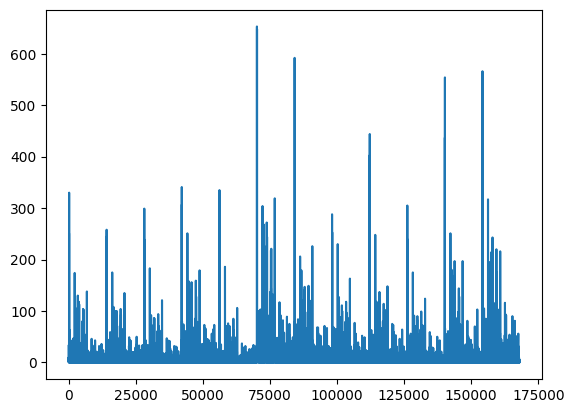

In [208]:
plt.plot(data_now_stocks['quantity'])
plt.show()

In [209]:
temp = pd.read_csv("./data/test/test_results.csv")

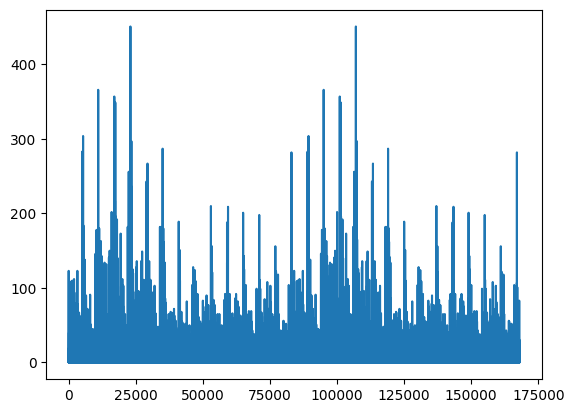

In [210]:
plt.plot(temp['x_k'])
plt.show()

In [211]:
data_now_stocks.rename(columns={'quantity': 'x_k'}, inplace=True)
data_now_stocks['x_m'] = 0
data_now_stocks

,store_id,sku_id,date,x_k,x_m
0,1,1,2023-09-01,2.0,0
1,1,1,2023-09-02,3.0,0
2,1,1,2023-09-03,3.0,0
3,1,1,2023-09-04,2.0,0
4,1,1,2023-09-05,1.0,0
...,...,...,...,...,...
167995,12,1000,2023-09-10,2.0,0
167996,12,1000,2023-09-11,1.0,0
167997,12,1000,2023-09-12,1.0,0
167998,12,1000,2023-09-13,1.0,0


In [212]:
data_now_stocks.to_csv("./submit/csv/test_results_11_12_partial_365.csv", index=False)